# US-Net

## Camus Dataset

### Patients

Lets first analyze dataset by reading Info files

In [2]:
from os import path

def read_info(patient, view = '2CH'):
    info_file_name = 'Info_'+view+'.cfg'
    info_file_path = path.join(patient, info_file_name)
    
    def remove_newline(line):
        return line[:-1]
    
    def keyvalue_pair(data):
        [key, value_str] = data.split(':')
        value_str = value_str.strip()
        return [key, value_str]
    
    with open(info_file_path, 'r') as file:
        patient_data = dict()
        info_string = file.readlines()
        info_string = list(map(remove_newline, info_string))
        info = list(map(keyvalue_pair, info_string))
        patient_data.update({'ed':float(info[0][1])})
        patient_data.update({'es':float(info[1][1])})
        patient_data.update({'nframe':int(info[2][1])})
        patient_data.update({'sex':info[3][1]})
        patient_data.update({'age':int(info[4][1])})
        patient_data.update({'image_quality':info[5][1]})
        patient_data.update({'lvedv':float(info[6][1])})
        patient_data.update({'lvesv':float(info[7][1])})
        patient_data.update({'lvef':float(info[8][1])})
        patient_data.update({'view':view})
        
        
    return patient_data

In [3]:
from glob import glob
import pandas as pd

patients = glob(r'data/training/*')

patient_db = list()
for patient in patients:
    patient_data = read_info(patient)
    patient_db.append(patient_data)
    patient_data = read_info(patient, view='4CH')
    patient_db.append(patient_data)
    
patient_db = pd.DataFrame(patient_db)
patient_db

,ed,es,nframe,sex,age,image_quality,lvedv,lvesv,lvef,view
0,1.0,18.0,18,F,56,Good,94.0,34.6,63.2,2CH
1,1.0,20.0,20,F,56,Good,94.0,34.6,63.2,4CH
2,1.0,17.0,17,M,55,Medium,119.1,60.3,49.4,2CH
3,1.0,15.0,15,M,55,Medium,119.1,60.3,49.4,4CH
4,1.0,17.0,17,F,36,Good,105.7,47.1,55.4,2CH
...,...,...,...,...,...,...,...,...,...,...
795,1.0,22.0,22,M,68,Medium,51.8,12.0,76.8,4CH
796,1.0,16.0,16,F,75,Medium,78.4,25.5,67.5,2CH
797,1.0,18.0,18,F,75,Good,78.4,25.5,67.5,4CH
798,1.0,15.0,15,F,74,Good,89.1,50.4,43.4,2CH


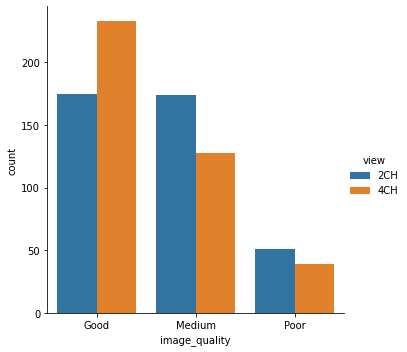

In [4]:
import seaborn as sns

sns.catplot(data=patient_db, x='image_quality', kind='count', hue='view')

## Prepare the data

## Load data

In [5]:
import tensorflow as tf
import tensorflow_io as tfio

import matplotlib.pyplot as plt

import cv2

In [6]:
from glob import glob
from os import path


def isimage(fileaddress):
    filename = path.basename(fileaddress).split('.')[0]
    if filename.endswith('gt') or filename.endswith('sequence'):
        return False
    else:
        return True

def is2ch_view(fileaddress):
    filename = path.basename(fileaddress)
    view = filename.split('_')[1]
    if view=='2CH':
        return True
    else:
        return False

def issequence(fileaddress):
    filename = path.basename(fileaddress).split('.')[0]
    if filename.endswith('sequence'):
        return True



In [7]:
TRAIN_DATASET_PATH = r'data/training'
VALIDATION_DATASET_PATH = r'data/validation'


path_structure = path.join(TRAIN_DATASET_PATH, r'*/*.raw')
file_paths = glob(path_structure)
train_images = list(filter(isimage, file_paths))
sequences = list(filter(issequence, file_paths))

path_structure = path.join(VALIDATION_DATASET_PATH, r'*/*.raw')
file_paths = glob(path_structure)
validation_images = list(filter(isimage, file_paths))
sequences.extend(list(filter(issequence, file_paths)))

Now that we have our image files in place, let's make our dataset:

In [8]:
@tf.function
def read_raw_image(image_path, target_size=(128, 128)):
    imgfile = tf.io.read_file(image_path)
    img_fileadd = tf.strings.split(image_path, '.')[0]
    mhd_fileadd = tf.strings.join([img_fileadd, '.mhd'])
    img_dims = read_mhd_data(mhd_fileadd)
    def correct_dims(dims):
        dims_correct = [dims[1], dims[0], dims[2]]
        dims_correct = tf.stack(dims_correct, axis=0)
        return dims_correct
    imgbytes = tf.io.decode_raw(imgfile, out_type=tf.uint8)
    img = tf.reshape(imgbytes, correct_dims(img_dims))
    img = tf.cast(img, tf.float32)
    img = (img - tf.math.reduce_min(img))/(tf.math.reduce_max(img) - tf.math.reduce_min(img))
    img = tf.image.resize(img, target_size)
    img = tf.repeat(img, 3, axis=2)
    return img


@tf.function
def read_mask_image(image_path, target_size=(128, 128)):
    imgfile = tf.io.read_file(image_path)
    img_fileadd = tf.strings.split(image_path, '.')[0]
    mhd_fileadd = tf.strings.join([img_fileadd, '.mhd'])
    img_dims = read_mhd_data(mhd_fileadd)
    def correct_dims(dims):
        dims_correct = [dims[1], dims[0], dims[2]]
        dims_correct = tf.stack(dims_correct, axis=0)
        return dims_correct
    imgbytes = tf.io.decode_raw(imgfile, out_type=tf.uint8)
    img = tf.reshape(imgbytes, correct_dims(img_dims))
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, target_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return img


@tf.function
def read_mhd_data(mhd_address):
    file_metadata_string = tf.io.read_file(mhd_address)
    print(file_metadata_string)
    # Complete this function later
    
@tf.function
def read_image_and_mask(input_address):
    image = read_raw_image(input_address)
    mask_fileadd = tf.strings.split(input_address, '.')[0]
    mask_fileadd = tf.strings.join([mask_fileadd, '_gt.raw'])
    mask_fileadd = tf.squeeze(mask_fileadd)
    mask = read_mask_image(mask_fileadd)
    return (image, mask)

@tf.function
def read_mhd_data(mhd_address):
    mhd_data_file = tf.io.read_file(mhd_address)
    mhd_lines = tf.strings.split(mhd_data_file, '\n')
    mhd_lines = tf.strings.split(mhd_lines, ' = ')
    dimsize = mhd_lines[10][1]
    dimsize = tf.strings.split(dimsize, ' ')
    dimsize = tf.boolean_mask(dimsize, mask=tf.math.logical_not(tf.math.equal(dimsize, b'')))
    #dimsize_new = tf.map_fn(tf.strings.to_number, dimsize)
    dimsize = tf.strings.to_number(dimsize)
    dimsize = tf.cast(dimsize, tf.int32)
    #element_number_of_channels = tf.strings.to_number(mhd_lines[11][1])
    return dimsize
    

train_ds_path = tf.data.Dataset.from_tensor_slices(train_images)
train_ds = train_ds_path.map(read_image_and_mask)

validation_ds_path = tf.data.Dataset.from_tensor_slices(validation_images)
validation_ds = validation_ds_path.map(read_image_and_mask)

In [9]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000


train_ds = (
    train_ds
      .cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .prefetch(buffer_size=tf.data.AUTOTUNE)
    )


validation_ds = validation_ds.batch(BATCH_SIZE)

In [10]:
train_ds

<PrefetchDataset shapes: ((None, 128, 128, None), (None, 128, 128, None)), types: (tf.float32, tf.float32)>

## Deep Learning Model

### Base Model
For the baseline, we will use the model in this [tensorflow Tutorial](https://www.tensorflow.org/tutorials/images/segmentation). The model cosists of a mobilenet v2 and pix2pix upsampling layers.

In [12]:
!pip install git+https://github.com/tensorflow/examples.git

You should consider upgrading via the 'c:\users\sepehr\projects\usnet\usnet_venv\scripts\python.exe -m pip install --upgrade pip' command.



  Cloning https://github.com/tensorflow/examples.git to c:\users\sepehr\appdata\local\temp\pip-req-build-qmq3skms
  Created wheel for tensorflow-examples: filename=tensorflow_examples-56524742e739278cc52e2fcfc978e81d64cfcbd3_-py3-none-any.whl size=270407 sha256=0fc0acb84924da009f1c0bf5a4fb23ed0fd3bd57153277e09748c0e1ecfb0e18
  Stored in directory: C:\Users\Sepehr\AppData\Local\Temp\pip-ephem-wheel-cache-9da2suaz\wheels\4e\f5\c2\bfe75b834c9028b2529023bf74541c46ead531b513a8010d21
Successfully built tensorflow-examples


In [41]:
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt

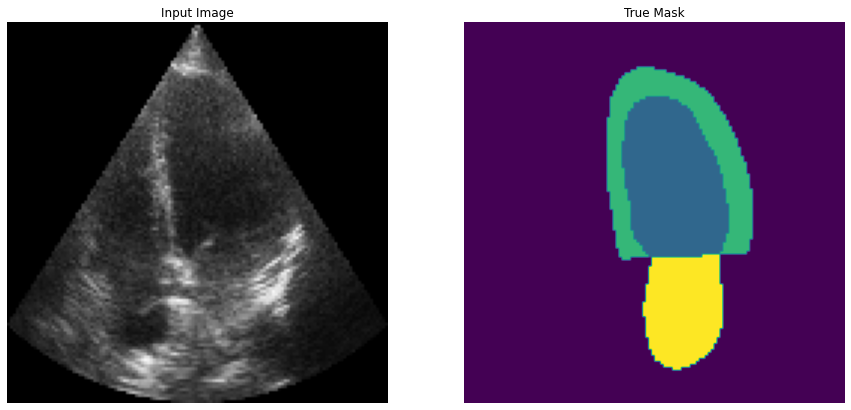

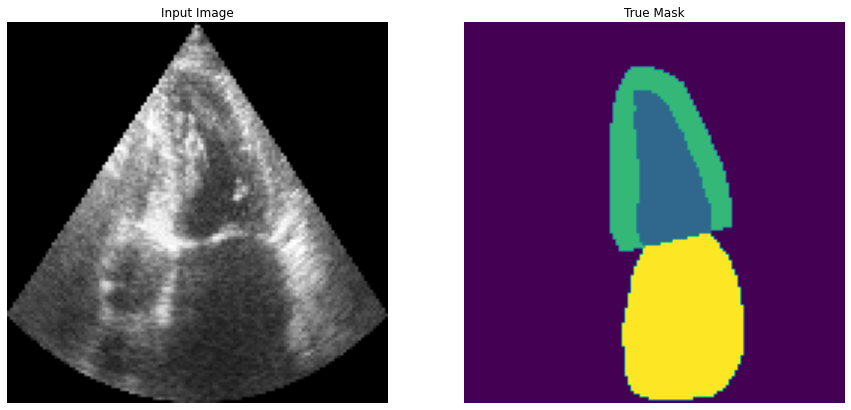

In [11]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()


for images, masks in train_ds.take(2):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])

In [43]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [44]:
with tf.device('/GPU:0'):
    up_stack = [
        pix2pix.upsample(512, 3),  # 4x4 -> 8x8
        pix2pix.upsample(256, 3),  # 8x8 -> 16x16
        pix2pix.upsample(128, 3),  # 16x16 -> 32x32
        pix2pix.upsample(64, 3),   # 32x32 -> 64x64
    ]

In [45]:
def unet_model(output_channels:int):
    
    with tf.device('/GPU:0'):
        inputs = tf.keras.layers.Input(shape=[128, 128, 3])

        # Downsampling through the model
        skips = down_stack(inputs)
        x = skips[-1]
        skips = reversed(skips[:-1])

        # Upsampling and establishing the skip connections
        for up, skip in zip(up_stack, skips):
            x = up(x)
            concat = tf.keras.layers.Concatenate()
            x = concat([x, skip])

        # This is the last layer of the model
        last = tf.keras.layers.Conv2DTranspose(
            filters=output_channels, kernel_size=3, strides=2,
            padding='same')  #64x64 -> 128x128

        x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [46]:
OUTPUT_CLASSES = 4

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [47]:
tf.keras.utils.plot_model(model, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [48]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model_4 (Functional)            [(None, 64, 64, 96), 1841984     input_6[0][0]                    
__________________________________________________________________________________________________
sequential_12 (Sequential)      (None, 8, 8, 512)    1476608     model_4[0][4]                    
__________________________________________________________________________________________________
concatenate_8 (Concatenate)     (None, 8, 8, 1088)   0           sequential_12[0][0]              
                                                                 model_4[0][3]              

(128, 128, 1)


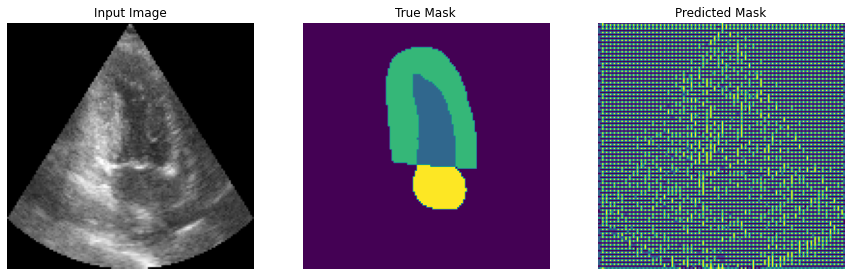

In [49]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        print(sample_mask.shape)
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])
    
show_predictions()

In [50]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [51]:
from tensorflow.keras.callbacks import TensorBoard

tb = TensorBoard('logs')
callbacks = [tb, DisplayCallback()]

__main__.DisplayCallback

(128, 128, 1)


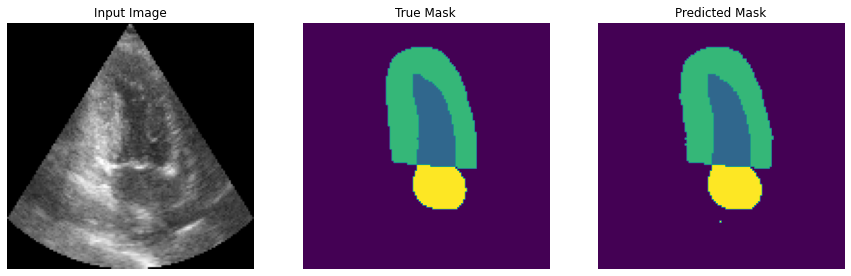


Sample Prediction after epoch 200



In [53]:
EPOCHS = 200

model_history = model.fit(train_ds, epochs=EPOCHS,
                          callbacks=callbacks, validation_data = validation_ds)

In [55]:
model.save('usnet')

INFO:tensorflow:Assets written to: usnet\assets


### Article Model

In this part we will try to exaclty define the U-Net model according to the article. As described in the article, the first part of our model is VGG-Net and the synthesizer part is 3D U-Net.


VGG-Net Article:
>K. Simonyan and A. Zisserman. (Sep. 2014). “Very deep convolutional networks for large-scale image recognition.” [Online]. Available: https://arxiv.org/abs/1409.1556

3D U-Net:
>O. Ronneberger, P. Fischer, and T. Brox, “U-net: Convolutional networks for biomedical image segmentation,” in Proc. Int. Conf. MICCAI, 2015, pp. 234–241.

In [12]:
base_model = tf.keras.applications.vgg16.VGG16(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
# layer_names = [
#     'block1_conv1',
#     'block1_conv2',
#     'block1_pool',
#     'block2_conv1',
#     'block2_conv2',
#     'block2_pool',
#     'block3_conv1',
#     'block3_conv2',
#     'block3_conv3',
#     'block3_pool'
# ]


layer_names = [
    'block1_conv2',
    'block2_conv2',
    'block3_conv3',
    'block4_conv3'
]

base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [13]:
down_stack.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [14]:
from tensorflow_examples.models.pix2pix import pix2pix

with tf.device('/GPU:0'):
    up_stack = [
        pix2pix.upsample(128, 3),  # 16x16 -> 32x32
        pix2pix.upsample(64, 3),   # 32x32 -> 64x64
    ]

In [15]:
def unet_model(output_channels:int):
    
    with tf.device('/GPU:0'):
        inputs = tf.keras.layers.Input(shape=[128, 128, 3])

        # Downsampling through the model
        skips = down_stack(inputs)
        x = skips[-1]
        skips = reversed(skips[:-1])

        # Upsampling and establishing the skip connections
        for up, skip in zip(up_stack, skips):
            x = up(x)
            concat = tf.keras.layers.Concatenate()
            x = concat([x, skip])

        # This is the last layer of the model
        last = tf.keras.layers.Conv2DTranspose(
            filters=output_channels, kernel_size=3, strides=2,
            padding='same')  #64x64 -> 128x128

        x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [31]:
a = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

print(a[0:6:2])

[1, 3, 5]


In [16]:
OUTPUT_CLASSES = 4

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, 128, 128, 64 7635264     input_2[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 32, 32, 128)  590336      model[0][3]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 32, 32, 384)  0           sequential[0][0]                 
                                                                 model[0][2]                

(128, 128, 1)


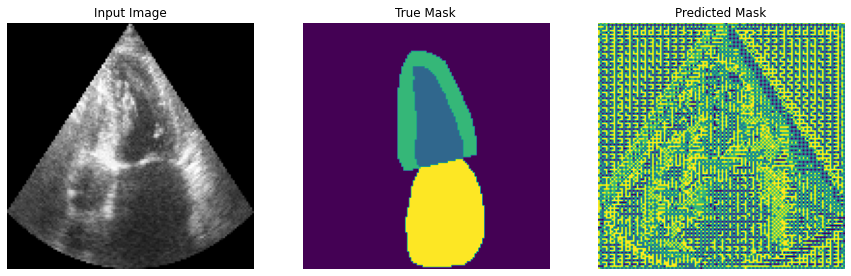

In [18]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        print(sample_mask.shape)
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])
    
show_predictions()

In [19]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))


from tensorflow.keras.callbacks import TensorBoard

tb = TensorBoard('logs/exp02')
callbacks = [tb, DisplayCallback()]

In [20]:
EPOCHS = 200

model_history = model.fit(train_ds, epochs=EPOCHS,
                          callbacks=callbacks, validation_data = validation_ds)

Epoch 1/200


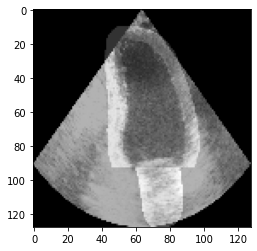

In [36]:
import time




def read_raw_seq(image_path):
    imgfile = tf.io.read_file(image_path)
    imgbytes = tf.io.decode_raw(imgfile, out_type=tf.uint8)
    img = tf.reshape(imgbytes, (-1, 778, 549))
    return img


def play_sequence(sequence_array):
    cap = cv2.VideoCapture()
    has_frames = True
    frame_counter = 0
    while True:
        frame = sequence_array[frame_counter, :, :]
        cv2.imshow('frame',frame)
        time.sleep(0.1)
        frame_counter+=1
        if frame_counter==sequence_array.shape[0]:
            frame_counter = 0
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()
    
    
img = read_raw_image(r'patient0001/patient0001_2CH_ED.raw')
mask = read_raw_image(r'patient0001/patient0001_2CH_ED_gt.raw')
plt.imshow(img, 'gray')
plt.imshow(mask, 'viridis', alpha=0.3)
#play_sequence(seq.numpy())


### Read Sequence

In [ ]:
seq = read_raw_seq(r'patient0001/patient0001_4CH_sequence.raw')
play_sequence(seq.numpy())

Now we should convert these file addresses to tensorflow datasets